In [1]:
import os
import utils

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from rnn import RNN, masked_mse_loss, train_rnn

In [2]:
NUM_SEQUENCES = 121

SEQUENCE_STRIDE = 10

BATCH_SIZE = 16
RNN_HIDDEN_SIZE = 256
MLP_HIDDEN_SIZE = 1024
NUM_LAYERS = 2
LEARNING_RATE = 1e-3
NUM_EPOCH_CONVERGENCE = 8

In [3]:
def pad_inputs_and_targets(inputs, targets):
    inputs = nn.utils.rnn.pad_sequence(inputs)
    targets = nn.utils.rnn.pad_sequence(targets)
    
    return inputs, targets

In [4]:
inputs, targets, seq_lengths = utils.load_data(['initial'],
                                               sequence_stride=SEQUENCE_STRIDE,
                                               recurrent=True)

splits = (0.7, 0.85)

train_inputs, valid_inputs, test_inputs = utils.split(inputs, splits)
train_targets, valid_targets, test_targets = utils.split(targets, splits)
train_lengths, valid_lengths, test_lengths = utils.split(seq_lengths, splits)

# Pad inputs and targets
train_inputs, train_targets = pad_inputs_and_targets(train_inputs, train_targets)
valid_inputs, valid_targets = pad_inputs_and_targets(valid_inputs, valid_targets)
test_inputs, test_targets = pad_inputs_and_targets(test_inputs, test_targets)

# Transform lengths into tensor
train_lengths = torch.tensor(train_lengths)
valid_lengths = torch.tensor(valid_lengths)
test_lengths = torch.tensor(test_lengths)

# Standardization statistics
train_max_length = train_lengths.max().item()
num_train = train_inputs.size(1)
input_size = train_inputs.size(-1)
output_size = train_targets.size(-1)
timesteps = torch.arange(train_max_length).expand(num_train, train_max_length)
masks = (timesteps < train_lengths.unsqueeze(1)).T.unsqueeze(-1)

train_inputs_flatten = train_inputs[masks.expand(-1, -1, input_size)]
train_inputs_flatten = train_inputs_flatten.view(-1, input_size)
train_targets_flatten = train_targets[masks.expand(-1, -1, output_size)]
train_targets_flatten = train_targets_flatten.view(-1, output_size)

mean_inputs = train_inputs_flatten.mean(dim=0)
std_inputs = train_inputs_flatten.std(dim=0)
mean_targets = train_targets_flatten.mean(dim=0)
std_targets = train_targets_flatten.std(dim=0)

rnn = RNN(
    cell='gru',
    input_size=train_inputs.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs,
    std_inputs=std_inputs,
    mean_targets=mean_targets,
    std_targets=std_targets)

opt = optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

tensor([383, 345, 221, 626, 566,   0, 265, 721, 262, 211, 301,  87, 555, 122,
         59, 723, 434,  75, 328,  11, 576, 230, 353, 427, 607,   6, 183, 196,
        649, 624, 452, 673, 177, 133, 461,  17, 293, 186, 311,  57, 639, 182,
        459, 215, 699, 593, 377, 332, 224, 364, 132, 229, 240, 208, 295, 667,
         32, 536, 161,  82, 252, 238,   2, 616, 280,   4, 169, 104, 674, 222,
        331, 194, 413, 205, 315, 237, 519, 171,  88, 469, 255, 455, 379, 348,
        609, 558,   7, 551, 431, 283, 633, 276, 267,  25,  81, 274,  50, 107,
        447, 416, 637, 476,  24, 693, 465, 176, 502, 304,  95,  96, 109,  52,
        640, 493, 370, 375, 700, 201, 535, 145, 713, 405, 106, 148, 512, 631,
        482, 541,  38, 123, 592, 679, 432, 396, 603, 249, 124,  48, 245, 309,
        402, 684, 523, 686, 271, 219, 346,   3, 500, 454, 225, 606,  83, 533,
        197, 421, 326, 216, 347, 590, 185, 570, 257, 296, 634,  53, 562, 456,
        371, 522, 617, 698, 514, 506, 557,  97, 275, 294, 233, 3

In [7]:
stats = train_rnn(rnn, opt, train_inputs, train_targets, train_lengths,
    valid_inputs, valid_targets, valid_lengths, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 62,538.6864
	Train after epoch: 39,752.5938
	Valid: 38,254.5977
Epoch 002
	Train: 26,927.0369
	Train after epoch: 8,901.7012
	Valid: 8,801.8311
Epoch 003
	Train: 7,450.8856
	Train after epoch: 3,749.8867
	Valid: 3,673.3906
Epoch 004
	Train: 2,908.2874
	Train after epoch: 1,850.1465
	Valid: 1,807.2677
Epoch 005
	Train: 1,531.8539
	Train after epoch: 1,081.7181
	Valid: 1,063.1145
Epoch 006
	Train: 808.4457
	Train after epoch: 567.0451
	Valid: 552.5120
Epoch 007
	Train: 655.5778
	Train after epoch: 565.7915
	Valid: 528.2901
Epoch 008
	Train: 564.7952
	Train after epoch: 323.1819
	Valid: 317.7341
Epoch 009
	Train: 273.8345
	Train after epoch: 225.1933
	Valid: 224.9204
Epoch 010
	Train: 405.8556
	Train after epoch: 280.4541
	Valid: 274.8555
Epoch 011
	Train: 210.5605
	Train after epoch: 152.7698
	Valid: 148.4532
Epoch 012
	Train: 141.6320
	Train after epoch: 145.8877
	Valid: 148.9721
Epoch 013
	Train: 229.1047
	Train after epoch: 134.2148
	Valid: 135.2404
Epoch 014
	Train:

In [8]:
name = 'init_position'
os.makedirs('../results/', exist_ok=True)
df = pd.DataFrame.from_dict(stats)
df.to_csv('../results/rnn-{}.csv'.format(name))

In [9]:
with torch.no_grad():
    test_preds, _ = rnn(test_inputs)

mse_loss = masked_mse_loss(test_preds, test_targets, test_lengths,
                           test_lengths.max().item())
print('Test MSE Loss: {:,.4f}'.format(mse_loss.item()))

os.makedirs('../weights/', exist_ok=True)
weights_file = '../weights/rnn-{}.pth'.format(name)
torch.save(rnn.state_dict(), weights_file)

Test MSE Loss: 29.4456


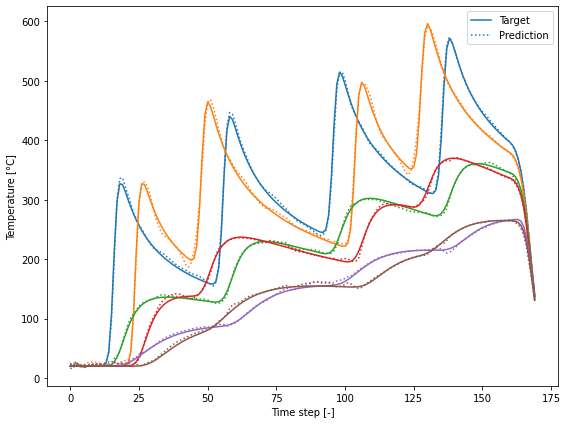

In [19]:
utils.show_sample_sequence(
    test_targets, test_preds, test_lengths, recurrent=True)

### 1 RNN / point

In [3]:
def compute_statistics(inputs, targets, lengths):

    # Standardization statistics
    max_length = lengths.max().item()
    num_samples = inputs.size(1)
    input_size = inputs.size(-1)
    output_size = targets.size(-1)
    timesteps = torch.arange(max_length).expand(num_samples, max_length)
    masks = (timesteps < lengths.unsqueeze(1)).T.unsqueeze(-1)

    inputs_flatten = inputs[masks.expand(-1, -1, input_size)]
    inputs_flatten = inputs_flatten.view(-1, input_size)
    targets_flatten = targets[masks.expand(-1, -1, output_size)]
    targets_flatten = targets_flatten.view(-1, output_size)

    mean_inputs = inputs_flatten.mean(dim=0)
    std_inputs = inputs_flatten.std(dim=0)
    mean_targets = targets_flatten.mean(dim=0)
    std_targets = targets_flatten.std(dim=0)
    
    return mean_inputs, std_inputs, mean_targets, std_targets

In [26]:
# Load data per point
train_dataset_P1, valid_dataset_P1, test_dataset_P1 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=True, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=1)
train_inputs_P1, train_targets_P1, train_lengths_P1 = train_dataset_P1
valid_inputs_P1, valid_targets_P1, valid_lengths_P1 = valid_dataset_P1
test_inputs_P1, test_targets_P1, test_lengths_P1 = test_dataset_P1
mean_inputs_P1, std_inputs_P1, mean_targets_P1, std_targets_P1 = compute_statistics(train_inputs_P1, 
                                                                                    train_targets_P1,
                                                                                    train_lengths_P1
                                                                                   )

train_dataset_P2, valid_dataset_P2, test_dataset_P2 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=True, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=2)
train_inputs_P2, train_targets_P2, train_lengths_P2 = train_dataset_P2
valid_inputs_P2, valid_targets_P2, valid_lengths_P2 = valid_dataset_P2
test_inputs_P2, test_targets_P2, test_lengths_P2 = test_dataset_P2
mean_inputs_P2, std_inputs_P2, mean_targets_P2, std_targets_P2 = compute_statistics(train_inputs_P2, 
                                                                                    train_targets_P2,
                                                                                    train_lengths_P2
                                                                                   )

train_dataset_P3, valid_dataset_P3, test_dataset_P3 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=True, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=3)
train_inputs_P3, train_targets_P3, train_lengths_P3 = train_dataset_P3
valid_inputs_P3, valid_targets_P3, valid_lengths_P3 = valid_dataset_P3
test_inputs_P3, test_targets_P3, test_lengths_P3 = test_dataset_P3
mean_inputs_P3, std_inputs_P3, mean_targets_P3, std_targets_P3 = compute_statistics(train_inputs_P3, 
                                                                                    train_targets_P3,
                                                                                    train_lengths_P3
                                                                                   )

train_dataset_P4, valid_dataset_P4, test_dataset_P4 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=True, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=4)
train_inputs_P4, train_targets_P4, train_lengths_P4 = train_dataset_P4
valid_inputs_P4, valid_targets_P4, valid_lengths_P4 = valid_dataset_P4
test_inputs_P4, test_targets_P4, test_lengths_P4 = test_dataset_P4
mean_inputs_P4, std_inputs_P4, mean_targets_P4, std_targets_P4 = compute_statistics(train_inputs_P4, 
                                                                                    train_targets_P4,
                                                                                    train_lengths_P4
                                                                                   )

train_dataset_P5, valid_dataset_P5, test_dataset_P5 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=True, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=5)
train_inputs_P5, train_targets_P5, train_lengths_P5 = train_dataset_P5
valid_inputs_P5, valid_targets_P5, valid_lengths_P5 = valid_dataset_P5
test_inputs_P5, test_targets_P5, test_lengths_P5 = test_dataset_P5
mean_inputs_P5, std_inputs_P5, mean_targets_P5, std_targets_P5 = compute_statistics(train_inputs_P5, 
                                                                                    train_targets_P5,
                                                                                    train_lengths_P5
                                                                                   )

train_dataset_P6, valid_dataset_P6, test_dataset_P6 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=True, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=6)
train_inputs_P6, train_targets_P6, train_lengths_P6 = train_dataset_P6
valid_inputs_P6, valid_targets_P6, valid_lengths_P6 = valid_dataset_P6
test_inputs_P6, test_targets_P6, test_lengths_P6 = test_dataset_P6
mean_inputs_P6, std_inputs_P6, mean_targets_P6, std_targets_P6 = compute_statistics(train_inputs_P6, 
                                                                                    train_targets_P6,
                                                                                    train_lengths_P6
                                                                                   )

In [5]:
RNN_P1 = RNN(
    cell='gru',
    input_size=train_inputs_P1.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets_P1.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs_P1,
    std_inputs=std_inputs_P1,
    mean_targets=mean_targets_P1,
    std_targets=std_targets_P1)
opt_1 = optim.Adam(RNN_P1.parameters(), lr=LEARNING_RATE)

RNN_P2 = RNN(
    cell='gru',
    input_size=train_inputs_P2.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets_P2.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs_P2,
    std_inputs=std_inputs_P2,
    mean_targets=mean_targets_P2,
    std_targets=std_targets_P2)
opt_2 = optim.Adam(RNN_P2.parameters(), lr=LEARNING_RATE)

RNN_P3 = RNN(
    cell='gru',
    input_size=train_inputs_P3.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets_P3.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs_P3,
    std_inputs=std_inputs_P3,
    mean_targets=mean_targets_P3,
    std_targets=std_targets_P3)
opt_3 = optim.Adam(RNN_P3.parameters(), lr=LEARNING_RATE)

RNN_P4 = RNN(
    cell='gru',
    input_size=train_inputs_P4.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets_P4.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs_P4,
    std_inputs=std_inputs_P4,
    mean_targets=mean_targets_P4,
    std_targets=std_targets_P4)
opt_4 = optim.Adam(RNN_P4.parameters(), lr=LEARNING_RATE)

RNN_P5 = RNN(
    cell='gru',
    input_size=train_inputs_P5.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets_P5.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs_P5,
    std_inputs=std_inputs_P5,
    mean_targets=mean_targets_P5,
    std_targets=std_targets_P5)
opt_5 = optim.Adam(RNN_P5.parameters(), lr=LEARNING_RATE)

RNN_P6 = RNN(
    cell='gru',
    input_size=train_inputs_P6.size(2),
    rnn_hidden_size=RNN_HIDDEN_SIZE,
    mlp_hidden_size=MLP_HIDDEN_SIZE,
    output_size=train_targets_P6.size(2),
    num_layers=NUM_LAYERS,
    mean_inputs=mean_inputs_P6,
    std_inputs=std_inputs_P6,
    mean_targets=mean_targets_P6,
    std_targets=std_targets_P6)
opt_6 = optim.Adam(RNN_P6.parameters(), lr=LEARNING_RATE)

In [6]:
stats_P1 = train_rnn(RNN_P1, opt_1, train_inputs_P1, train_targets_P1, train_lengths_P1,
    valid_inputs_P1, valid_targets_P1, valid_lengths_P1, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 120,475.9812
	Train after epoch: 78,449.3359
	Valid: 79,695.4453
Epoch 002
	Train: 91,936.0312
	Train after epoch: 77,514.0938
	Valid: 78,870.8359
Epoch 003
	Train: 88,472.7563
	Train after epoch: 70,651.9141
	Valid: 71,826.5547
Epoch 004
	Train: 83,004.7109
	Train after epoch: 60,167.5039
	Valid: 61,873.9180
Epoch 005
	Train: 69,727.6812
	Train after epoch: 50,543.8594
	Valid: 52,318.6406
Epoch 006
	Train: 56,571.0719
	Train after epoch: 37,855.7031
	Valid: 37,816.1211
Epoch 007
	Train: 48,604.1273
	Train after epoch: 34,271.5352
	Valid: 34,911.0430
Epoch 008
	Train: 45,115.7371
	Train after epoch: 29,629.0391
	Valid: 30,074.7988
Epoch 009
	Train: 41,533.1023
	Train after epoch: 30,243.2676
	Valid: 31,381.4746
Epoch 010
	Train: 38,608.3836
	Train after epoch: 31,040.6387
	Valid: 31,947.5488
Epoch 011
	Train: 34,043.1230
	Train after epoch: 26,189.1641
	Valid: 26,568.1641
Epoch 012
	Train: 31,346.2512
	Train after epoch: 20,621.6914
	Valid: 20,997.9082
Epoch 013
	Trai

In [7]:
stats_P2 = train_rnn(RNN_P2, opt_2, train_inputs_P2, train_targets_P2, train_lengths_P2,
    valid_inputs_P2, valid_targets_P2, valid_lengths_P2, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 129,236.6313
	Train after epoch: 86,797.8672
	Valid: 88,467.7656
Epoch 002
	Train: 108,110.5734
	Train after epoch: 82,677.6406
	Valid: 84,153.2344
Epoch 003
	Train: 96,213.0391
	Train after epoch: 71,632.4375
	Valid: 72,478.3516
Epoch 004
	Train: 76,580.8836
	Train after epoch: 49,116.8828
	Valid: 49,434.3398
Epoch 005
	Train: 55,571.3039
	Train after epoch: 39,613.5586
	Valid: 40,998.5625
Epoch 006
	Train: 43,325.2621
	Train after epoch: 36,601.5117
	Valid: 37,197.6172
Epoch 007
	Train: 46,437.9816
	Train after epoch: 32,998.0938
	Valid: 34,016.8320
Epoch 008
	Train: 41,936.2566
	Train after epoch: 29,271.5371
	Valid: 31,382.8379
Epoch 009
	Train: 36,767.4527
	Train after epoch: 36,253.0547
	Valid: 38,303.5859
Epoch 010
	Train: 34,970.8734
	Train after epoch: 28,194.4355
	Valid: 29,243.2656
Epoch 011
	Train: 35,128.9566
	Train after epoch: 21,076.9629
	Valid: 21,408.6719
Epoch 012
	Train: 28,242.4010
	Train after epoch: 22,128.3848
	Valid: 22,790.1113
Epoch 013
	Tra

In [8]:
stats_P3 = train_rnn(RNN_P3, opt_3, train_inputs_P3, train_targets_P3, train_lengths_P3,
    valid_inputs_P3, valid_targets_P3, valid_lengths_P3, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 79,504.4102
	Train after epoch: 55,106.0469
	Valid: 55,425.8047
Epoch 002
	Train: 62,461.4469
	Train after epoch: 47,719.6719
	Valid: 48,183.0703
Epoch 003
	Train: 54,660.0586
	Train after epoch: 44,704.6875
	Valid: 45,445.4141
Epoch 004
	Train: 52,622.3516
	Train after epoch: 39,045.0430
	Valid: 39,753.3398
Epoch 005
	Train: 43,858.1570
	Train after epoch: 30,686.6328
	Valid: 31,593.1387
Epoch 006
	Train: 35,509.8027
	Train after epoch: 30,923.2637
	Valid: 33,463.8789
Epoch 007
	Train: 36,268.5266
	Train after epoch: 25,586.6699
	Valid: 25,154.7754
Epoch 008
	Train: 27,248.5273
	Train after epoch: 27,631.8379
	Valid: 29,654.1543
Epoch 009
	Train: 22,735.8822
	Train after epoch: 17,751.5742
	Valid: 15,666.7314
Epoch 010
	Train: 16,846.2124
	Train after epoch: 23,834.3633
	Valid: 24,031.1074
Epoch 011
	Train: 24,456.1371
	Train after epoch: 10,652.3574
	Valid: 9,934.5723
Epoch 012
	Train: 13,419.5823
	Train after epoch: 9,067.9795
	Valid: 8,518.4375
Epoch 013
	Train: 8

In [9]:
stats_P4 = train_rnn(RNN_P4, opt_4, train_inputs_P4, train_targets_P4, train_lengths_P4,
    valid_inputs_P4, valid_targets_P4, valid_lengths_P4, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 89,357.0414
	Train after epoch: 59,258.4961
	Valid: 59,779.4336
Epoch 002
	Train: 69,878.9352
	Train after epoch: 53,682.9609
	Valid: 53,978.0977
Epoch 003
	Train: 66,667.1242
	Train after epoch: 48,083.9219
	Valid: 48,533.6055
Epoch 004
	Train: 50,811.8703
	Train after epoch: 32,833.7461
	Valid: 33,502.9102
Epoch 005
	Train: 40,785.5160
	Train after epoch: 24,214.4980
	Valid: 23,583.3652
Epoch 006
	Train: 33,383.0703
	Train after epoch: 29,396.4277
	Valid: 31,204.8242
Epoch 007
	Train: 29,574.8746
	Train after epoch: 20,249.6582
	Valid: 20,125.2930
Epoch 008
	Train: 20,975.9406
	Train after epoch: 14,933.9688
	Valid: 14,235.3945
Epoch 009
	Train: 15,891.6410
	Train after epoch: 10,515.1816
	Valid: 9,972.9365
Epoch 010
	Train: 10,428.2572
	Train after epoch: 8,584.3271
	Valid: 8,741.3008
Epoch 011
	Train: 22,765.8450
	Train after epoch: 9,912.8955
	Valid: 9,220.0361
Epoch 012
	Train: 10,112.3117
	Train after epoch: 5,621.8862
	Valid: 5,436.3701
Epoch 013
	Train: 7,868

In [10]:
stats_P5 = train_rnn(RNN_P5, opt_5, train_inputs_P5, train_targets_P5, train_lengths_P5,
    valid_inputs_P5, valid_targets_P5, valid_lengths_P5, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 59,165.2914
	Train after epoch: 40,895.1016
	Valid: 40,772.6875
Epoch 002
	Train: 42,041.6695
	Train after epoch: 35,444.5547
	Valid: 35,523.9336
Epoch 003
	Train: 40,699.2508
	Train after epoch: 32,996.4570
	Valid: 33,357.1641
Epoch 004
	Train: 43,303.1422
	Train after epoch: 32,042.8418
	Valid: 32,421.2754
Epoch 005
	Train: 36,760.9770
	Train after epoch: 29,583.2949
	Valid: 29,999.5059
Epoch 006
	Train: 34,321.4621
	Train after epoch: 27,143.9141
	Valid: 27,817.0098
Epoch 007
	Train: 33,103.7965
	Train after epoch: 20,732.7500
	Valid: 20,999.1113
Epoch 008
	Train: 29,364.5668
	Train after epoch: 26,224.2812
	Valid: 27,238.7344
Epoch 009
	Train: 25,058.3584
	Train after epoch: 16,236.3408
	Valid: 15,154.4883
Epoch 010
	Train: 17,371.4693
	Train after epoch: 13,677.2529
	Valid: 11,663.0908
Epoch 011
	Train: 12,370.8510
	Train after epoch: 8,386.1826
	Valid: 7,398.8286
Epoch 012
	Train: 8,182.8198
	Train after epoch: 3,507.1377
	Valid: 2,932.0798
Epoch 013
	Train: 3,1

In [11]:
stats_P6 = train_rnn(RNN_P6, opt_6, train_inputs_P6, train_targets_P6, train_lengths_P6,
    valid_inputs_P6, valid_targets_P6, valid_lengths_P6, BATCH_SIZE,
    NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 64,853.1836
	Train after epoch: 43,304.0312
	Valid: 43,429.1875
Epoch 002
	Train: 48,770.9008
	Train after epoch: 38,398.2773
	Valid: 38,729.6523
Epoch 003
	Train: 45,270.7812
	Train after epoch: 36,011.5352
	Valid: 36,526.6133
Epoch 004
	Train: 42,173.8375
	Train after epoch: 34,464.0312
	Valid: 34,902.9609
Epoch 005
	Train: 39,381.3926
	Train after epoch: 31,125.2246
	Valid: 31,548.6738
Epoch 006
	Train: 33,642.7520
	Train after epoch: 24,984.5625
	Valid: 25,737.9238
Epoch 007
	Train: 27,797.2266
	Train after epoch: 15,580.2383
	Valid: 14,778.0303
Epoch 008
	Train: 19,662.1805
	Train after epoch: 23,663.7812
	Valid: 20,834.7148
Epoch 009
	Train: 23,299.6775
	Train after epoch: 12,164.1475
	Valid: 11,373.8574
Epoch 010
	Train: 15,953.1662
	Train after epoch: 15,180.2568
	Valid: 12,647.5547
Epoch 011
	Train: 15,034.2267
	Train after epoch: 9,733.4385
	Valid: 7,879.0225
Epoch 012
	Train: 10,558.7919
	Train after epoch: 7,374.8691
	Valid: 7,495.3916
Epoch 013
	Train: 6,

In [12]:
os.makedirs('../results/', exist_ok=True)

all_stats = [stats_P1, stats_P2, stats_P3, stats_P4, stats_P5, stats_P6]
for i, stats in enumerate(all_stats):
    df = pd.DataFrame.from_dict(stats)
    df.to_csv('../results/rnn-P_{}.csv'.format(i+1), index=False)

Test MSE Loss: 188.8945


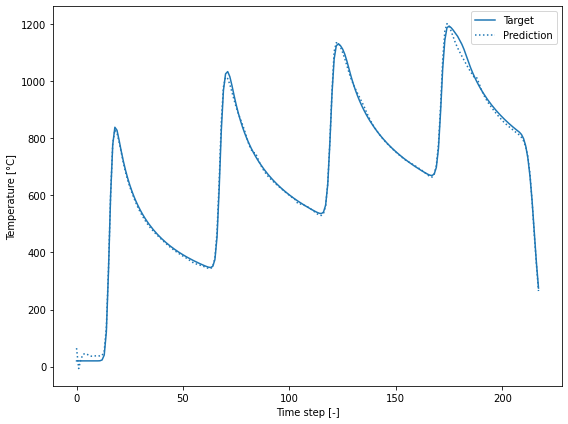

Test MSE Loss: 176.7863


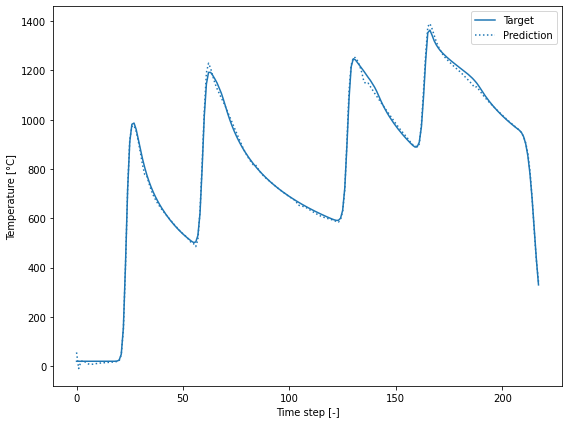

Test MSE Loss: 46.4444


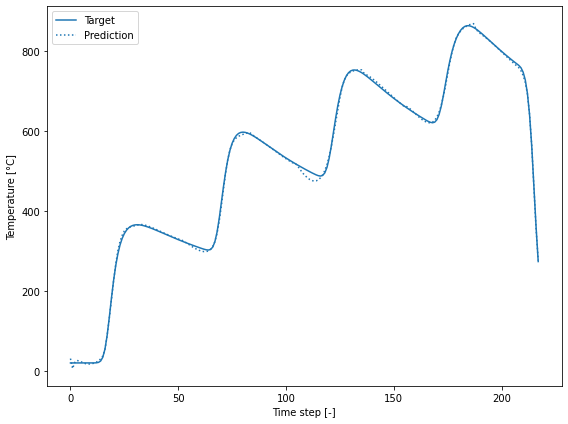

Test MSE Loss: 25.2437


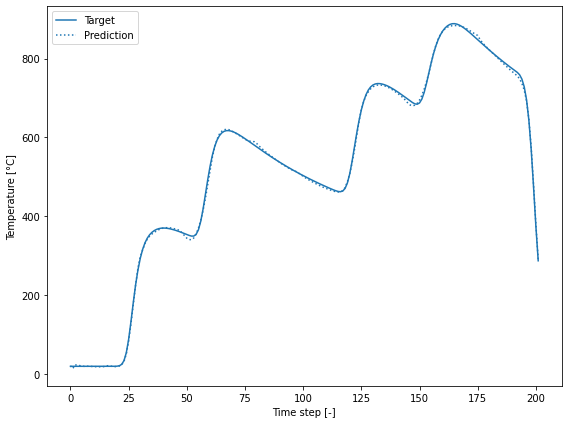

Test MSE Loss: 269.5943


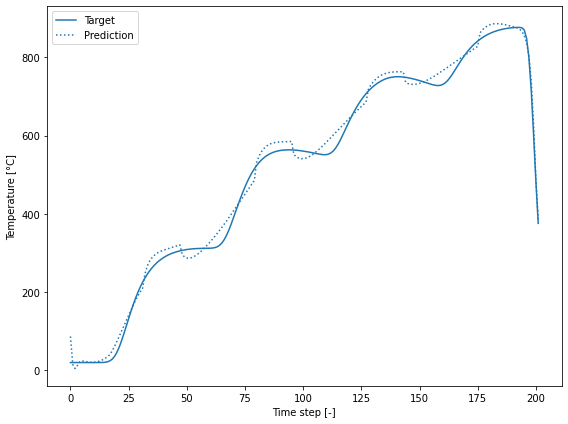

Test MSE Loss: 140.8411


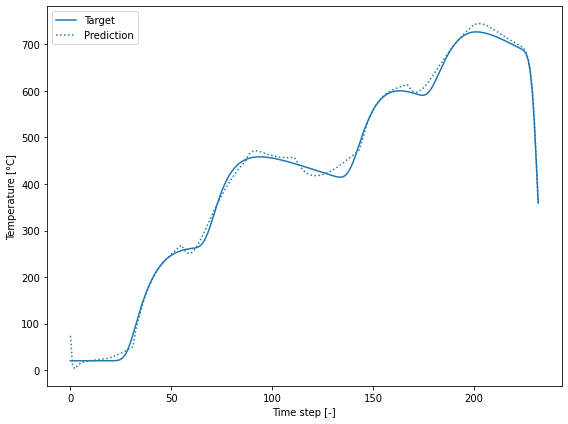

141.3007049560547


In [28]:
models = [(RNN_P1, test_dataset_P1), (RNN_P2, test_dataset_P2), 
          (RNN_P3, test_dataset_P3), (RNN_P4, test_dataset_P4), 
          (RNN_P5, train_dataset_P5), (RNN_P6, test_dataset_P6)]

MSE = []
for i, (model, test_dataset) in enumerate(models):
    test_inputs, test_targets, test_lengths = test_dataset
    with torch.no_grad():
        test_preds, _ = model(test_inputs)

    mse_loss = masked_mse_loss(test_preds, test_targets, test_lengths,
                               test_lengths.max().item())
    MSE.append(mse_loss)
    print('Test MSE Loss: {:,.4f}'.format(mse_loss.item()))

    os.makedirs('../weights/', exist_ok=True)
    weights_file = '../weights/rnn-P_{}.pth'.format(i+1)
    torch.save(model.state_dict(), weights_file)
    
    utils.show_sample_sequence(
    test_targets, test_preds, test_lengths, recurrent=True)
    
print((sum(MSE)/len(MSE)).item())

### 1 MLP / point

In [14]:
BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_HIDDEN = 2
LEARNING_RATE = 1e-3
NUM_EPOCH_CONVERGENCE = 8

In [30]:
# Load data per point
train_dataset_P1, valid_dataset_P1, test_dataset_P1 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=False, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=1)
train_inputs_P1, train_targets_P1, train_lengths_P1 = train_dataset_P1
valid_inputs_P1, valid_targets_P1, valid_lengths_P1 = valid_dataset_P1
test_inputs_P1, test_targets_P1, test_lengths_P1 = test_dataset_P1
mean_inputs_P1 = train_inputs_P1.mean(dim=0)
std_inputs_P1 = train_inputs_P1.std(dim=0)
mean_targets_P1 = train_targets_P1.mean(dim=0)
std_targets_P1 = train_targets_P1.std(dim=0)

train_dataset_P2, valid_dataset_P2, test_dataset_P2 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=False, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=2)
train_inputs_P2, train_targets_P2, train_lengths_P2 = train_dataset_P2
valid_inputs_P2, valid_targets_P2, valid_lengths_P2 = valid_dataset_P2
test_inputs_P2, test_targets_P2, test_lengths_P2 = test_dataset_P2
mean_inputs_P2 = train_inputs_P2.mean(dim=0)
std_inputs_P2 = train_inputs_P2.std(dim=0)
mean_targets_P2 = train_targets_P2.mean(dim=0)
std_targets_P2 = train_targets_P2.std(dim=0)

train_dataset_P3, valid_dataset_P3, test_dataset_P3 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=False, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=3)
train_inputs_P3, train_targets_P3, train_lengths_P3 = train_dataset_P3
valid_inputs_P3, valid_targets_P3, valid_lengths_P3 = valid_dataset_P3
test_inputs_P3, test_targets_P3, test_lengths_P3 = test_dataset_P3
mean_inputs_P3 = train_inputs_P3.mean(dim=0)
std_inputs_P3 = train_inputs_P3.std(dim=0)
mean_targets_P3 = train_targets_P3.mean(dim=0)
std_targets_P3 = train_targets_P3.std(dim=0)

train_dataset_P4, valid_dataset_P4, test_dataset_P4 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=False, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=4)
train_inputs_P4, train_targets_P4, train_lengths_P4 = train_dataset_P4
valid_inputs_P4, valid_targets_P4, valid_lengths_P4 = valid_dataset_P4
test_inputs_P4, test_targets_P4, test_lengths_P4 = test_dataset_P4
mean_inputs_P4 = train_inputs_P4.mean(dim=0)
std_inputs_P4 = train_inputs_P4.std(dim=0)
mean_targets_P4 = train_targets_P4.mean(dim=0)
std_targets_P4 = train_targets_P4.std(dim=0)

train_dataset_P5, valid_dataset_P5, test_dataset_P5 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=False, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=5)
train_inputs_P5, train_targets_P5, train_lengths_P5 = train_dataset_P5
valid_inputs_P5, valid_targets_P5, valid_lengths_P5 = valid_dataset_P5
test_inputs_P5, test_targets_P5, test_lengths_P5 = test_dataset_P5
mean_inputs_P5 = train_inputs_P5.mean(dim=0)
std_inputs_P5 = train_inputs_P5.std(dim=0)
mean_targets_P5 = train_targets_P5.mean(dim=0)
std_targets_P5 = train_targets_P5.std(dim=0)

train_dataset_P6, valid_dataset_P6, test_dataset_P6 = utils.train_valid_test_split(
    range(1, NUM_SEQUENCES + 1), recurrent=False, train_ratio=0.7,
    sequence_stride=SEQUENCE_STRIDE, point=6)
train_inputs_P6, train_targets_P6, train_lengths_P6 = train_dataset_P6
valid_inputs_P6, valid_targets_P6, valid_lengths_P6 = valid_dataset_P6
test_inputs_P6, test_targets_P6, test_lengths_P6 = test_dataset_P6
mean_inputs_P6 = train_inputs_P6.mean(dim=0)
std_inputs_P6 = train_inputs_P6.std(dim=0)
mean_targets_P6 = train_targets_P6.mean(dim=0)
std_targets_P6 = train_targets_P6.std(dim=0)

In [17]:
from mlp import MLP, train_mlp

mlp_P1 = MLP(
        input_size=train_inputs_P1.size(1),
        hidden_size=HIDDEN_SIZE,
        output_size=train_targets_P1.size(1),
        num_hidden=NUM_HIDDEN,
        mean_inputs=mean_inputs_P1,
        std_inputs=std_inputs_P1,
        mean_targets=mean_targets_P1,
        std_targets=std_targets_P1)
opt_P1 = optim.Adam(mlp_P1.parameters(), lr=LEARNING_RATE)

mlp_P2 = MLP(
        input_size=train_inputs_P2.size(1),
        hidden_size=HIDDEN_SIZE,
        output_size=train_targets_P2.size(1),
        num_hidden=NUM_HIDDEN,
        mean_inputs=mean_inputs_P2,
        std_inputs=std_inputs_P2,
        mean_targets=mean_targets_P2,
        std_targets=std_targets_P2)
opt_P2 = optim.Adam(mlp_P2.parameters(), lr=LEARNING_RATE)

mlp_P3 = MLP(
        input_size=train_inputs_P3.size(1),
        hidden_size=HIDDEN_SIZE,
        output_size=train_targets_P3.size(1),
        num_hidden=NUM_HIDDEN,
        mean_inputs=mean_inputs_P3,
        std_inputs=std_inputs_P3,
        mean_targets=mean_targets_P3,
        std_targets=std_targets_P3)
opt_P3 = optim.Adam(mlp_P3.parameters(), lr=LEARNING_RATE)

mlp_P4 = MLP(
        input_size=train_inputs_P4.size(1),
        hidden_size=HIDDEN_SIZE,
        output_size=train_targets_P4.size(1),
        num_hidden=NUM_HIDDEN,
        mean_inputs=mean_inputs_P4,
        std_inputs=std_inputs_P4,
        mean_targets=mean_targets_P4,
        std_targets=std_targets_P4)
opt_P4 = optim.Adam(mlp_P4.parameters(), lr=LEARNING_RATE)

mlp_P5 = MLP(
        input_size=train_inputs_P5.size(1),
        hidden_size=HIDDEN_SIZE,
        output_size=train_targets_P5.size(1),
        num_hidden=NUM_HIDDEN,
        mean_inputs=mean_inputs_P5,
        std_inputs=std_inputs_P5,
        mean_targets=mean_targets_P5,
        std_targets=std_targets_P5)
opt_P5 = optim.Adam(mlp_P5.parameters(), lr=LEARNING_RATE)

mlp_P6 = MLP(
        input_size=train_inputs_P6.size(1),
        hidden_size=HIDDEN_SIZE,
        output_size=train_targets_P6.size(1),
        num_hidden=NUM_HIDDEN,
        mean_inputs=mean_inputs_P6,
        std_inputs=std_inputs_P6,
        mean_targets=mean_targets_P6,
        std_targets=std_targets_P6)
opt_P6 = optim.Adam(mlp_P6.parameters(), lr=LEARNING_RATE)

In [18]:
stats_P1 = train_mlp(mlp_P1, opt_P1, train_inputs_P1, train_targets_P1,
    valid_inputs_P1, valid_targets_P1, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 4307.3546
	Train after epoch: 177.0334
	Valid: 168.3892
Epoch 002
	Train: 330.4180
	Train after epoch: 330.4765
	Valid: 327.1248
Epoch 003
	Train: 206.3174
	Train after epoch: 329.0825
	Valid: 321.5167
Epoch 004
	Train: 161.4788
	Train after epoch: 113.3199
	Valid: 104.5142
Epoch 005
	Train: 115.5162
	Train after epoch: 58.0559
	Valid: 56.0241
Epoch 006
	Train: 100.8573
	Train after epoch: 112.2947
	Valid: 110.8247
Epoch 007
	Train: 91.3187
	Train after epoch: 46.2162
	Valid: 42.4343
Epoch 008
	Train: 81.2454
	Train after epoch: 37.4157
	Valid: 37.6169
Epoch 009
	Train: 78.4082
	Train after epoch: 109.2036
	Valid: 109.6201
Epoch 010
	Train: 71.0058
	Train after epoch: 34.4097
	Valid: 33.4109
Epoch 011
	Train: 65.0597
	Train after epoch: 314.2560
	Valid: 309.8054
Epoch 012
	Train: 61.2059
	Train after epoch: 70.5028
	Valid: 69.6436
Epoch 013
	Train: 61.7585
	Train after epoch: 27.9764
	Valid: 28.3626
Epoch 014
	Train: 50.4980
	Train after epoch: 21.0993
	Valid: 22.3292

In [19]:
stats_P2 = train_mlp(mlp_P2, opt_P2, train_inputs_P2, train_targets_P2,
    valid_inputs_P2, valid_targets_P2, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 4354.8000
	Train after epoch: 985.3237
	Valid: 939.5887
Epoch 002
	Train: 479.5229
	Train after epoch: 228.2791
	Valid: 220.0295
Epoch 003
	Train: 300.2952
	Train after epoch: 196.7571
	Valid: 165.4774
Epoch 004
	Train: 209.7665
	Train after epoch: 74.4363
	Valid: 71.4920
Epoch 005
	Train: 175.2510
	Train after epoch: 99.7286
	Valid: 84.9986
Epoch 006
	Train: 149.2670
	Train after epoch: 84.7512
	Valid: 84.5149
Epoch 007
	Train: 119.7003
	Train after epoch: 147.8261
	Valid: 148.5605
Epoch 008
	Train: 112.2264
	Train after epoch: 165.9031
	Valid: 159.4194
Epoch 009
	Train: 99.5631
	Train after epoch: 88.5464
	Valid: 84.1554
Epoch 010
	Train: 90.3189
	Train after epoch: 38.9515
	Valid: 39.2561
Epoch 011
	Train: 85.2928
	Train after epoch: 66.1352
	Valid: 66.9797
Epoch 012
	Train: 74.9940
	Train after epoch: 42.9920
	Valid: 40.6662
Epoch 013
	Train: 73.0618
	Train after epoch: 74.7885
	Valid: 71.9546
Epoch 014
	Train: 71.3035
	Train after epoch: 243.1171
	Valid: 224.0278

In [31]:
stats_P3 = train_mlp(mlp_P3, opt_P3, train_inputs_P3, train_targets_P3,
    valid_inputs_P3, valid_targets_P3, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 95.6740
	Train after epoch: 20.5507
	Valid: 20.7867
Epoch 002
	Train: 21.4486
	Train after epoch: 24.2245
	Valid: 23.7899
Epoch 003
	Train: 19.0827
	Train after epoch: 9.2901
	Valid: 8.8732
Epoch 004
	Train: 15.7546
	Train after epoch: 19.3473
	Valid: 18.2258
Epoch 005
	Train: 15.3033
	Train after epoch: 14.1872
	Valid: 14.2114
Epoch 006
	Train: 14.2770
	Train after epoch: 4.7278
	Valid: 5.4543
Epoch 007
	Train: 12.8449
	Train after epoch: 6.4854
	Valid: 6.5328
Epoch 008
	Train: 12.1615
	Train after epoch: 5.6724
	Valid: 6.0939
Epoch 009
	Train: 11.9517
	Train after epoch: 4.3029
	Valid: 4.5480
Epoch 010
	Train: 10.3871
	Train after epoch: 11.5998
	Valid: 12.4635
Epoch 011
	Train: 11.3656
	Train after epoch: 5.2573
	Valid: 6.0919
Epoch 012
	Train: 10.1432
	Train after epoch: 6.4860
	Valid: 6.9964
Epoch 013
	Train: 10.4236
	Train after epoch: 19.4277
	Valid: 19.0933
Epoch 014
	Train: 9.4575
	Train after epoch: 5.2373
	Valid: 5.3158
Epoch 015
	Train: 9.4763
	Train after

In [32]:
stats_P4 = train_mlp(mlp_P4, opt_P4, train_inputs_P4, train_targets_P4,
    valid_inputs_P4, valid_targets_P4, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 130.3005
	Train after epoch: 52.5479
	Valid: 53.8203
Epoch 002
	Train: 90.3194
	Train after epoch: 23.8177
	Valid: 24.9695
Epoch 003
	Train: 50.6441
	Train after epoch: 12.3674
	Valid: 13.5411
Epoch 004
	Train: 49.1277
	Train after epoch: 36.1748
	Valid: 36.9799
Epoch 005
	Train: 36.9464
	Train after epoch: 15.0066
	Valid: 15.4964
Epoch 006
	Train: 32.7428
	Train after epoch: 49.3870
	Valid: 47.4237
Epoch 007
	Train: 27.0313
	Train after epoch: 11.7257
	Valid: 13.8007
Epoch 008
	Train: 25.6557
	Train after epoch: 17.8342
	Valid: 17.9303
Epoch 009
	Train: 20.4545
	Train after epoch: 20.1009
	Valid: 21.1259
Epoch 010
	Train: 21.1951
	Train after epoch: 15.5459
	Valid: 14.3175
Epoch 011
	Train: 21.1489
	Train after epoch: 8.8221
	Valid: 9.6124
Epoch 012
	Train: 17.9514
	Train after epoch: 13.2264
	Valid: 14.4278
Epoch 013
	Train: 16.8072
	Train after epoch: 40.5295
	Valid: 37.5012
Epoch 014
	Train: 16.1712
	Train after epoch: 12.5469
	Valid: 12.4352
Epoch 015
	Train: 14.

In [33]:
stats_P5 = train_mlp(mlp_P5, opt_P5, train_inputs_P5, train_targets_P5,
    valid_inputs_P5, valid_targets_P5, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 166.3220
	Train after epoch: 32.7263
	Valid: 31.1070
Epoch 002
	Train: 33.3137
	Train after epoch: 33.8415
	Valid: 33.7855
Epoch 003
	Train: 22.8921
	Train after epoch: 9.7252
	Valid: 9.1437
Epoch 004
	Train: 15.7750
	Train after epoch: 13.8178
	Valid: 14.2025
Epoch 005
	Train: 12.2577
	Train after epoch: 7.0866
	Valid: 7.7909
Epoch 006
	Train: 11.5683
	Train after epoch: 26.2991
	Valid: 26.0749
Epoch 007
	Train: 10.2626
	Train after epoch: 13.9213
	Valid: 13.8902
Epoch 008
	Train: 8.8049
	Train after epoch: 2.7766
	Valid: 3.1771
Epoch 009
	Train: 7.8085
	Train after epoch: 5.2638
	Valid: 5.4833
Epoch 010
	Train: 8.2830
	Train after epoch: 2.3969
	Valid: 2.8184
Epoch 011
	Train: 7.2365
	Train after epoch: 6.0030
	Valid: 6.2364
Epoch 012
	Train: 7.0644
	Train after epoch: 12.6134
	Valid: 13.3910
Epoch 013
	Train: 6.3806
	Train after epoch: 4.5151
	Valid: 4.8178
Epoch 014
	Train: 6.1177
	Train after epoch: 3.9247
	Valid: 4.3013
Epoch 015
	Train: 6.2536
	Train after epoc

In [34]:
stats_P6 = train_mlp(mlp_P6, opt_P6, train_inputs_P6, train_targets_P6,
    valid_inputs_P6, valid_targets_P6, BATCH_SIZE, NUM_EPOCH_CONVERGENCE)

Epoch 001
	Train: 271.3408
	Train after epoch: 47.2403
	Valid: 47.8691
Epoch 002
	Train: 50.2255
	Train after epoch: 35.5840
	Valid: 34.9553
Epoch 003
	Train: 32.1349
	Train after epoch: 26.7023
	Valid: 24.5463
Epoch 004
	Train: 22.3110
	Train after epoch: 25.0195
	Valid: 24.2266
Epoch 005
	Train: 20.7305
	Train after epoch: 15.7367
	Valid: 16.3521
Epoch 006
	Train: 15.9680
	Train after epoch: 8.2363
	Valid: 8.6111
Epoch 007
	Train: 15.7365
	Train after epoch: 6.8607
	Valid: 6.6437
Epoch 008
	Train: 12.9077
	Train after epoch: 6.7322
	Valid: 7.2777
Epoch 009
	Train: 11.5468
	Train after epoch: 18.7662
	Valid: 18.8686
Epoch 010
	Train: 11.2949
	Train after epoch: 4.4491
	Valid: 4.3262
Epoch 011
	Train: 10.3697
	Train after epoch: 9.7741
	Valid: 8.7944
Epoch 012
	Train: 11.1759
	Train after epoch: 4.0295
	Valid: 4.3477
Epoch 013
	Train: 9.4035
	Train after epoch: 21.9357
	Valid: 20.2992
Epoch 014
	Train: 8.3823
	Train after epoch: 5.7340
	Valid: 5.9910
Epoch 015
	Train: 8.6054
	Train aft

In [35]:
os.makedirs('../results/', exist_ok=True)

all_stats = [stats_P1, stats_P2, stats_P3, stats_P4, stats_P5, stats_P6]
for i, stats in enumerate(all_stats):
    df = pd.DataFrame.from_dict(stats)
    df.to_csv('../results/mlp-P_{}.csv'.format(i+1), index=False)

Test MSE Loss: 13.5262


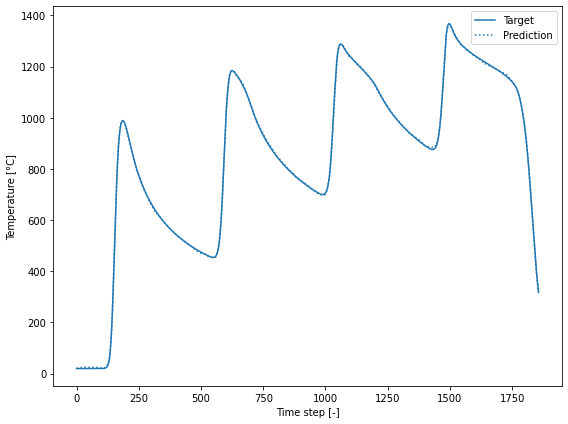

Test MSE Loss: 42.5442


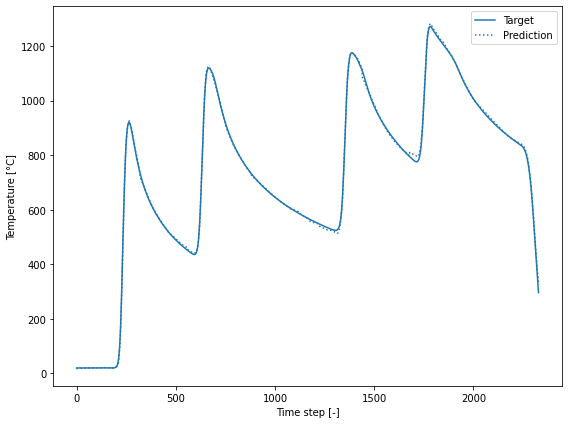

Test MSE Loss: 3.1367


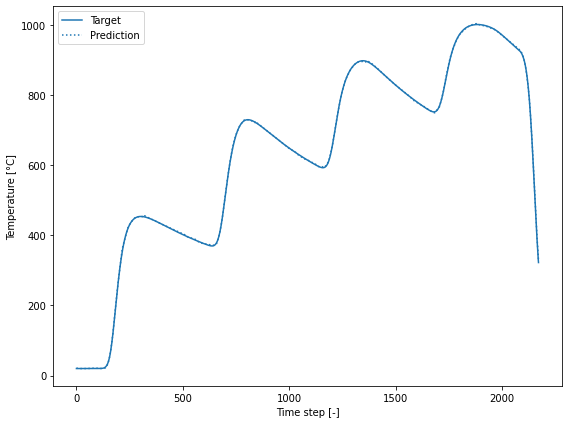

Test MSE Loss: 3.7877


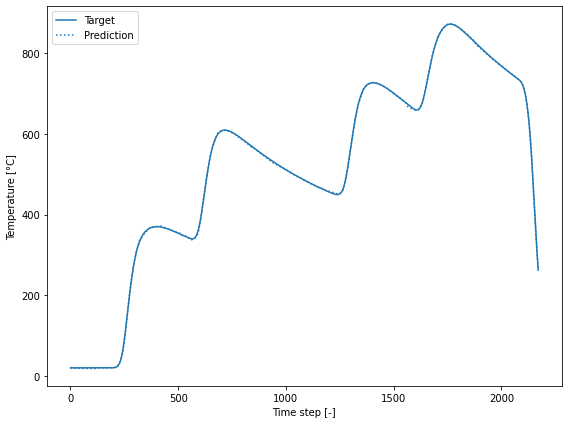

Test MSE Loss: 2.8134


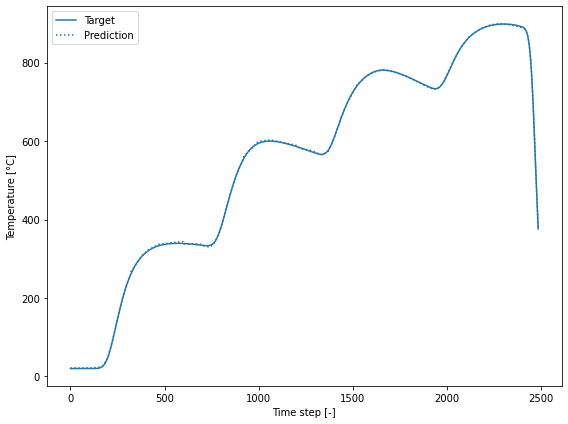

Test MSE Loss: 4.7640


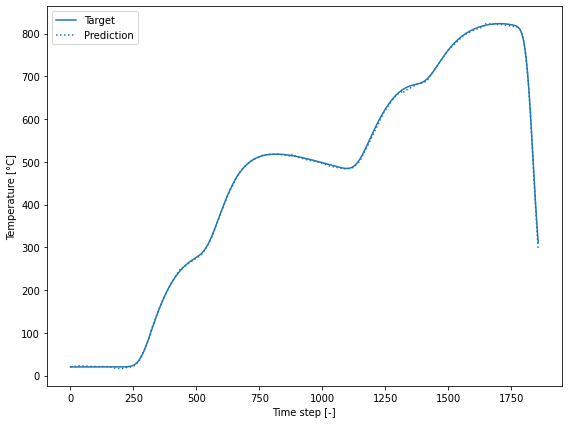

11.762036323547363


In [41]:
import torch.nn.functional as F

models = [(mlp_P1, test_dataset_P1), (mlp_P2, test_dataset_P2), 
          (mlp_P3, test_dataset_P3), (mlp_P4, test_dataset_P4), 
          (mlp_P5, test_dataset_P5), (mlp_P6, test_dataset_P6)]

MSE = []
for i, (model, test_dataset) in enumerate(models):
    test_inputs, test_targets, test_lengths = test_dataset
    with torch.no_grad():
        test_preds = model(test_inputs)

    mse_loss = F.mse_loss(test_preds, test_targets)
    MSE.append(mse_loss)
    print('Test MSE Loss: {:.4f}'.format(mse_loss.item()))

    os.makedirs('../weights/', exist_ok=True)
    weights_file = '../weights/mlp-P_{}.pth'.format(i+1)
    torch.save(model.state_dict(), weights_file)
    
    utils.show_sample_sequence(test_targets, test_preds, test_lengths, recurrent=False)
    
print((sum(MSE)/len(MSE)).item())